In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import tensorflow as tf

import nengo_dl

from scipy.signal import decimate

In [2]:
from src.io.psee_loader import PSEELoader

import pathlib
from glob import glob

In [18]:
delta_t = 20000
n = 75
skip = 100

Process and load Phrophasee dataset

In [19]:
vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

#print(event_seqs[0])

In [20]:
dat = np.zeros((n, delta_t, 30, 30),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

print(train_data.shape, test_data.shape)

(60, 20000, 900) (15, 20000, 900)


Process and load MNIST dataset

In [26]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
#train_data = train_data.reshape((train_data.shape[0], 1, -1))
#test_data = test_data.reshape((test_data.shape[0], 1, -1))

train_data = np.repeat(train_data[:, np.newaxis,:], 10, axis=1)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1],-1))

test_data = np.repeat(test_data[:, np.newaxis,:], 10, axis=1)
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1],-1))

n_epochs = 2
n_in = train_data.shape[1]

print(train_data.shape)

(60000, 10, 784)


In [7]:
with nengo.Network() as auto_net:
    n_in = train_data.shape[2]
    n_hidden=64

    #auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    #auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    #auto_net.config[nengo.Connection].synapse = 0.005

    #neuron_type = nengo.RectifiedLinear()
    #neuron_type = nengo.LIFRate()
    neuron_type=nengo.SpikingRectifiedLinear()
    #neuron_type = nengo.LIF()
    
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=neuron_type)
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())#, synapse=0.001)

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=neuron_type)
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot())#, synapse=0.001)
    

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)
    p_b = nengo.Probe(nengo_b.neurons)

# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

In [18]:
inp_sz = train_data.shape[2]

In [21]:
n_epochs = 2
minibatch_size = 8

with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    #sim.evaluate(test_data, test_data)

    # Save the model
    #sim.save_params("./rate_relu_mnist")
    #sim.save_params("./rate_LIF_mnist")
    #sim.save_params("./spike_relu_mnist")
    #sim.save_params("./spike_LIF_mnist")

    #sim.save_params("./rate_relu_DVS")
    #sim.save_params("./rate_LIF_DVS")
    sim.save_params("./spike_relu_DVS")
    #sim.save_params("./spike_LIF_DVS")

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Cons

In [22]:
n_epochs = 10
minibatch_size = 8
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    #sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    #sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    #sim.evaluate(test_data, test_data)

    # Load the saved model
    #sim.load_params("./LIF_mnist1")
    #sim.load_params("./LIF_prophesee")

    #sim.load_params("./rate_relu_mnist")
    #sim.load_params("./rate_LIF_mnist")
    #sim.load_params("./spike_relu_mnist")
    #sim.load_params("./spike_LIF_mnist")

    #sim.load_params("./rate_relu_DVS")
    #sim.load_params("./rate_LIF_DVS")
    sim.load_params("./spike_relu_DVS")
    #sim.load_params("./spike_LIF_DVS")

    # display example output
    output = sim.predict(train_data[:minibatch_size])
    #plt.figure()
    #plt.imshow(output[p_c][0].reshape((30, 30)))
    #plt.show()
    print(output[p_c].shape)



    '''# display the latent space representation
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_b][0].reshape((8, 8)))
    plt.show()

    hidden_rep = output[p_b][0]
    norm = np.linalg.norm(hidden_rep)
    hidden_rep = hidden_rep/norm
    print('Mean of the hidden space rep:', hidden_rep.mean())'''

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Cons

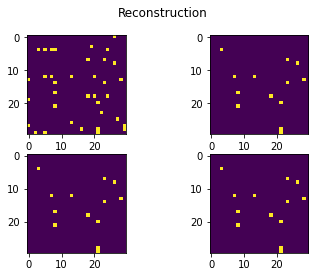

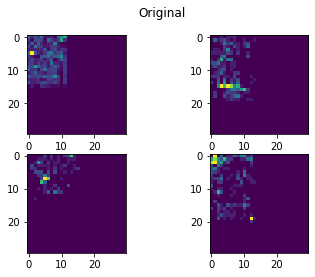

In [23]:
plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    final_image = output[p_c][i].sum(0)
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((30, 30)))
    plt.suptitle('Reconstruction')
plt.show()

    #print(final_image.reshape((28, 28)))
plt.figure()
for i in range(4):
    input_image = train_data[i].sum(0)
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(input_image.reshape((30, 30)))
    plt.suptitle('Original')
plt.show()

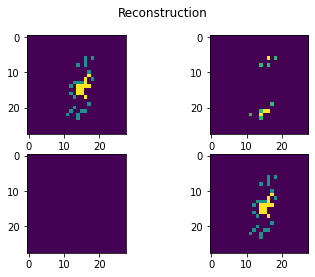

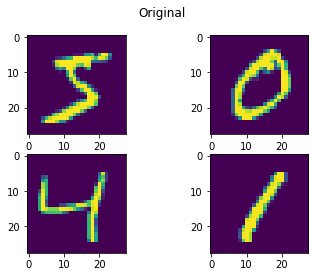

In [42]:
plt.figure()
for i in range(4):
    # Integrate through time for each location while displaying final image
    final_image = output[p_c][i].sum(0)
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(final_image.reshape((28, 28)))
    plt.suptitle('Reconstruction')
plt.show()

    #print(final_image.reshape((28, 28)))
plt.figure()
for i in range(4):
    input_image = train_data[i].sum(0)
    #plt.figure()
    plt.subplot(2,2,i+1)
    plt.imshow(input_image.reshape((28, 28)))
    plt.suptitle('Original')
plt.show()

    #print(input_image.reshape((28, 28)))